<a href="https://colab.research.google.com/github/kandluis/premium-property-finder/blob/master/notebooks/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Requirements { display-mode: "form" }
!pip install requests-async aiohttp mypy folium nest-asyncio

# Simple mypy cell magic for Colab
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
from mypy import api

from google.colab import data_table
data_table.enable_dataframe_formatter()

import nest_asyncio
nest_asyncio.apply()

@register_cell_magic
def mypy(line, cell):
  for output in api.run(['-c', '\n' + cell] + line.split()):
    if output and not output.startswith('Success'):
      raise TypeError(output)
  get_ipython().run_cell(cell)

In [82]:
#@title Setup { display-mode: "form" }
%%mypy

import aiohttp
import asyncio
import dataclasses
import decimal
import enum
import folium # type: ignore
import json
import locale
import pandas as pd # type: ignore
import random
import re
from urllib import parse

from geographiclib import geodesic # type: ignore

from typing import Any, cast, Dict, Iterable, List, Mapping, Tuple, Optional, Union
from typing_extensions import TypedDict

@dataclasses.dataclass
class Secrets:
  MAPQUEST_API_KEY: str
  ZILLOW_API_KEY: str
  CUTTLY: str
  SECRET: str 

  @staticmethod
  def default():
    """Default initializer loads from secrets."""
    with open('/content/drive/MyDrive/.secrets', 'r') as f:
      data = json.load(f)
  
    return Secrets(**data)

@dataclasses.dataclass
class Globals:
  geocodingBaseUrl: str = 'https://www.mapquestapi.com/geocoding/v1/address'
  proxyUrl: str = 'https://premium-property-finder-server.fly.dev/proxy'
  dbEndpoint: str = 'https://premium-property-finder-server.fly.dev/api'
  zillowBaseUrl: str = 'https://www.zillow.com/search/GetSearchPageState.htm'
  zillowApiBaseUrl: str = 'https://www.zillow.com/webservice'
  rentBitsApiBaseUrl: str = 'https://service.rentbits.com/api/v1/search'

  keys = Secrets.default()

  _session: Optional[aiohttp.ClientSession] = None

@dataclasses.dataclass
class Location:
  lat: float
  lng: float

async def fetch(url: str) -> Dict[str, Any]:
  """Fetches the given URL through a CORS-Anywhere proxy."""
  user_agent_list = [
   "Mozilla/5.0 (Windows NT 10.0 Win64 x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36",
   "Mozilla/5.0 (Windows NT 6.1 Win64 x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36",
   "Mozilla/5.0 (iPad CPU OS 15_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/104.0.5112.99 Mobile/15E148 Safari/604.1"
]
  reffer_list=[
    'https://stackoverflow.com/',
    'https://twitter.com/',
    'https://www.google.co.in/',
    'https://gem.gov.in/'
  ]
  fullUrl = f"{Globals.proxyUrl}/{url}"
  headers = {
    'Api-Key': Globals.keys.SECRET,
    'X-Requested-With': 'XMLHttpRequest',
    'referer': random.choice(reffer_list),
    'User-Agent': random.choice(user_agent_list),
  }
  session = Globals._session
  assert session
  async with session.get(fullUrl, headers=headers) as response:
    if response.status != 200:
      return {
        "error": f"Failed to retrieve data from {fullUrl}. Response: {response}"
      }
    return await response.json()

async def getLatLong(location: str) -> Union[Location, Dict[str, Any]]:
  """Fetches the lat/long of a location.

  Args:
    location - The geo location. Could be zip code, address, state, etc.

  Returns: The coordinates of the location if we can find it.
  """
  geoCodeUrl = f"{Globals.geocodingBaseUrl}?key={Globals.keys.MAPQUEST_API_KEY}&location={location.lower()}"
  response = await fetch(geoCodeUrl)
  if not response.get('results', []) or not response['results'][0].get('locations', []):
    response['error'] += f"\n\nSuccessful response with empty locations for location: {location}"
    return response
  
  primaryResult = response['results'][0]['locations'][0]
  return Location(**primaryResult['latLng'])

@dataclasses.dataclass
class LocationBox:
  north: float
  east: float
  south: float
  west: float

def boundingBox(lat: float, lng: float, side: float) -> LocationBox:
  """
  Computes a bounding box around the (lat, lng) point with side lenghs of
  'side' miles.

  Works only for relatively small 'side' values (compared to earth radius)
  and when we're not too close to the poles.
  
  Args:
    lat - the latitude in degrees as a decimal.
    lng - the longitude in degrees as a decimal.
    side - the side length of the bounding box in miles.

  Returns: A LocationBox with degrees (either lat or long depending on direction)
    of the lines defining the bounding box.
  """
  radiusInMeters = side * 1.60934 * 1000 / 2
  geod = geodesic.Geodesic.WGS84
  return LocationBox(
    north=geod.Direct(lat, lng, 0, radiusInMeters)['lat2'],
    east=geod.Direct(lat, lng, 90, radiusInMeters)['lon2'],
    south=geod.Direct(lat, lng, 180, radiusInMeters)['lat2'],
    west=geod.Direct(lat, lng, 270, radiusInMeters)['lon2'],
  )

@enum.unique
class HomeType(enum.Enum):
  ALL = 'All'
  SINGLE_FAMILY = 'Single Family'
  LOT = 'Lot'
  MANUFACTURED = 'Manufactured'
  TOWNHOUSE = 'Townhouse'
  MULTI_FAMILY = 'Multi Family'

@dataclasses.dataclass
class Property:
  address: str
  detailUrl: str
  imgSrc: str
  price: decimal.Decimal
  statusType: str # Usually we check just for 'SOLD'. Have seen 'FOR_SALE'.
  statusText: str
  listingType: str # Usually just 'NEW_CONSTRUCTION'
  latitude: float
  longitude: float

  area: Optional[float] = None
  baths: Optional[int] = None
  beds: Optional[int] = None
  city: Optional[str] = None
  homeType: Optional[HomeType] = None
  lastSold: Optional[str] = None
  livingArea: Optional[float] = None
  lotArea: Optional[float] = None
  rentzestimate: Optional[decimal.Decimal] = None
  state: Optional[str] = None
  zestimate: Optional[float] = None
  zipCode: Optional[Union[int, str]] = None
  zpid: Optional[int] = None


def addHDPResults(parsedItem: Property, home: Any) -> None:
  """Adds a single HDP property result fetched from the Zillow API for an area.

  Args:
    parsedItem - The partially parsed item to which we add HDP data.
    home - The HDP home information object.
  """
  parsedItem.baths = home.get('bathrooms')
  parsedItem.beds = home.get('bedrooms')
  parsedItem.city = home.get('city')
  parsedItem.homeType = home.get('homeType')
  parsedItem.livingArea = home.get('livingArea')
  parsedItem.price = decimal.Decimal(home.get('price', parsedItem.price))
  parsedItem.rentzestimate = home.get('rentZestimate')
  parsedItem.state = home.get('state')
  parsedItem.zestimate = home.get('zestimate')
  parsedItem.zipCode = int(home['zipcode']) if 'zipcode' in home else None
  parsedItem.zpid = int(home['zpid']) if 'zpid' in home else None

def parsePrice(item: Mapping[str, Any]) -> decimal.Decimal:
  if not item.get('price'):
    return decimal.Decimal(0)
  
  localPrice = cast(str, item['price'])
  if localPrice[-1].upper() == 'M':
    # Only concat 5-zeros since we might include a '.'
    localPrice = localPrice.replace('M', '') + '00000'
    if '.' in localPrice:
      localPrice = localPrice.replace('.', '');
    else:
      # The missing zero.
      localPrice += '0'

  return decimal.Decimal(re.sub('[^(\d.)]', '', localPrice))


def addResults(parsedItem: Property, item: Mapping[str, Any]) -> None:
  """Adds same fields as above function but when we don't have HDP data."""
  if item.get('baths') or item.get('minBaths'):
    parsedItem.baths = int(cast(str, item.get('baths') or item.get('minBaths')))
  
  if item.get('beds') or item.get('minBeds'):
    parsedItem.beds = int(cast(str, item.get('beds') or item.get('minBeds')))

  if item.get('zpid'):
    parsedItem.zpid = int(cast(str, item.get('zpid')))


def parseResult(item: Any) -> Property:
  """Parses a single property result fetched from the Zillow API for an area.ZillowDB

  Args:
    item - The JSON object corresponding to a single property fetched from Zillow.

   Reeturns The parsed Property object.
  """
  parsedItem = Property(
    address=item.get('address'),
    detailUrl=item.get('detailUrl'),
    imgSrc=item.get('imgSrc'),
    listingType=item.get('listingType'),
    price=parsePrice(item),
    statusText=item.get('statusText'),
    statusType=item.get('statusType'),
    latitude=item.get('latLong', {}).get('latitude'),
    longitude=item.get('latLong', {}).get('longitude'),
  )
  if item.get('statusType') == 'SOLD' and item.get('variableData'):
    parsedItem.lastSold = item['variableData']['text'];

  # /something/address-seperated-by-city-state-zip.
  addressComponents = item['detailUrl'].split('/')[2].split('-')
  # These are best-effort. If we have more data, it gets replaced later.
  if addressComponents:
    try:
      parsedItem.zipCode = int(addressComponents[-1])
    except ValueError:
      parsedItem.zipCode = addressComponents[-1]
  if len(addressComponents) > 1:
    parsedItem.state = addressComponents[-2]
  if len(addressComponents) > 2:
    # This is not always valid. If a city is two words, we'll only get the
    # last one! :o
    parsedItem.city = addressComponents[-3]
  parsedItem.address = ' '.join(addressComponents[:-min(3, len(addressComponents))])
  if item.get('area') or item.get('minArea'):
    parsedItem.area = float(item.get('area') or item.get('minArea'))

  if item.get('lotAreaString'):
    parsedItem.lotArea = float(re.sub('[^(\d.)]', '', item.get('lotAreaString')))

  if item.get('hdpData'):
    addHDPResults(parsedItem, item.get('hdpData', {}).get('homeInfo', {}))
  else:
    addResults(parsedItem, item)

  return parsedItem

async def fetchProperties(
  geoLocation: str,
  radius: float,
  priceFrom: int,
  priceMost: int,
  includeRecentlySold: bool,
) -> List[Property]:
  """Fetches a list of properties currently for sale in the area surrounding the location.

  Might return properties outside the specified radius (but not by too much).

  Args:
    location - The location name as commonly referred (eg, Google Map-able)
    radius - The radius around the location within which we wish to find properties.
    priceFrom - The minimum price of any property returned.
    priceMost - The maximum price of any proeprty returned.
    includeRecentlySold - Whether or not to also include already sold listings.

  Returns: The located properties.
  """
  coords = await getLatLong(geoLocation)
  if isinstance(coords, Dict):
    return []
  box = boundingBox(coords.lat, coords.lng, radius * 2)
  if isinstance(box, Dict):
    return []
  wants = json.dumps({
    'cat1': ['mapResults'],
  }, separators=(',', ':'))
  def searchQueryStateFn(isRecentlySold: bool) -> str:
    return json.dumps({
      'mapBounds': dataclasses.asdict(box),
      'filterState': {
        'price': {
          'min': priceFrom,
          'max': priceMost,
        },
        'isAllHomes': { 'value': True },
        'isRecentlySold': { 'value': isRecentlySold },
        'isForSaleByAgent': { 'value': not isRecentlySold },
        'isForSaleByOwner': { 'value': not isRecentlySold },
        'isNewConstruction': { 'value': not isRecentlySold },
        'isComingSoon': { 'value': not isRecentlySold },
        'isAuction': { 'value': not isRecentlySold },
        'isForSaleForeclosure': { 'value': not isRecentlySold },
      },
    }, separators=(',', ':'))
  
  zillowUrl = f"{Globals.zillowBaseUrl}?searchQueryState={searchQueryStateFn(isRecentlySold=False)}&wants={wants}"
  data = await fetch(zillowUrl)
  propertyListings = data['cat1']['searchResults']['mapResults']
  if includeRecentlySold:
    zillowUrl = f"{Globals.zillowBaseUrl}?searchQueryState={searchQueryStateFn(isRecentlySold=True)}&wants={wants}"
    data = await fetch(zillowUrl)
    propertyListings += data['cat1']['searchResults']['mapResults']
  return [parseResult(prop) for prop in propertyListings if prop.get('zpid')]


async def getRentBitsEstimate(loc: Location) -> Optional[decimal.Decimal]:
  """Calculates the median known rental values in the given area using the rent bits API.

  Args:
    box - The bounding box in which to search for property estimates.

  Returns: The estimated price or null if not possible to estimate.
  """
  box = boundingBox(loc.lat, loc.lng, 1);
  url = f"{Globals.rentBitsApiBaseUrl}?bounds={box.south},{box.north},{box.west},{box.east}"
  res = await fetch(url)
  if 'error' in res or not res.get('data'):
    return None
  
  prices = [decimal.Decimal(re.sub('[^(\d.)]', '', item['price'])) 
    for item in res['data'] if item.get('price')]
  if not prices:
    return None

  mid = len(prices) // 2
  sortedPrices = sorted(prices)
  return (sortedPrices[mid - 1] + sortedPrices[mid]) / 2 if len(prices) % 2 == 0 else sortedPrices[mid]


async def fetchRentalBitsEstimates(properties: Iterable[Property]) -> Dict[Union[str, int], decimal.Decimal]:
  """Fetches the rental estimates from bits rental API.

  Args:
    properties: The properties for which to try and fetch a rental estimate.

  Returns: The database containing the estimated prices for each property.
  """
  # We only do this by zip code to reduce the load on the API.
  zips = set([item.zipCode for item in properties if item.zipCode ])
  rents: Dict[Union[int, str], decimal.Decimal] = {}
  # throttle = pThrottle({ limit: 5, interval: 3000 });
  # throttled = throttle(getRentBitsEstimate);
  async def fetch(zipCode: Union[int, str]) -> None:
    loc = await getLatLong(str(zipCode))
    if isinstance(loc, Dict):
      return
    rent = await getRentBitsEstimate(loc)
    if not rent:
      return
    rents[zipCode] = rent

  _ = await asyncio.gather(*[fetch(zipCode) for zipCode in zips], return_exceptions=True)
  # At this point we know that rents will have the right values set.
  return {
    prop.zpid : rents[prop.zipCode] for prop in properties
    if prop.zpid and prop.zipCode 
  }


async def attachRentestimates(properties: Iterable[Property]) -> List[Property]:
  """Attaches the Zillow zestimate for rent to each propertiy.

  Args:
    properties - The list of properties to which we attach a rental estimate.

  Returns: An array of properties with attached rental estimates.
  """
  needRentEstimates = [
    prop for prop in properties 
    # Properties we can compute a ratio for for which we need estimates.
    if not prop.rentzestimate and prop.zpid and prop.address and prop.zipCode and prop.price
  ]
  if not needRentEstimates:
    return list(properties)
  
  rentBitsEstimates = await fetchRentalBitsEstimates(needRentEstimates);
  def transform(prop: Property) -> Property:
    if not prop.zpid:
      return prop
    prop.rentzestimate = rentBitsEstimates.get(prop.zpid, prop.rentzestimate)
    return prop
  
  return [transform(prop) for prop in properties]

async def filterAndFetchProperties(
    geoLocation: str, radius: float, priceFrom: int, priceMost: int, includeSold: bool
) -> List[Property]:
  properties = await fetchProperties(
    geoLocation,
    radius,
    priceFrom,
    priceMost,
    includeSold,
  )
  return await attachRentestimates(properties)

def postProcess(data: pd.DataFrame) -> pd.DataFrame:
  """Cleans up adds additional metrics.

  Args;
    data - The dataframe built from the Property records.
  """

  # Clean-up 
  data = data.drop(
    labels=['imgSrc', 'statusType', 'listingType', 'area', 'lotArea', 'state', 
            'zpid', 'zipCode', 'statusText'],
    axis=1)
  maxPrice = data[['price', 'zestimate']].max(axis=1, numeric_only=True, skipna=True)
  data['detailUrl'] = data.detailUrl.map(lambda suffix: f'https://www.zillow.com{suffix}')
  data['price:estimate'] = data.price / data.zestimate
  data['rent:price'] = 100*data.rentzestimate / maxPrice
  data['price/ft'] = maxPrice / data.livingArea
  data['forSale'] = data.lastSold.isnull()

  return data
  

In [ ]:
#@title Filter Form { run: "auto", display-mode: "form" }
@dataclasses.dataclass
class FetchPropertiesRequest:
  geoLocation: str = 'Milpitas, CA' #@param { type: 'string'} 
  radius: float = 1.75 #@param { type: 'slider', min: 0.0, max: 4.0, step: 0.25 }
  priceFrom: int = 0
  priceMost: int = 1525000 #@param { type : 'slider', min: 100000, max: 3000000, step: 25000}
  includeSold: bool = True #@param { type : 'boolean' }


async def process(filter: FetchPropertiesRequest) -> Optional[Tuple[Location, LocationBox]]:
  async with aiohttp.ClientSession() as session:
    Globals._session = session
    loc = await getLatLong(filter.geoLocation)
    Globals._session = None
  
  if isinstance(locals, Dict):
    return None
  return loc, boundingBox(loc.lat, loc.lng, side=2*filter.radius)

def getMap(filter: FetchPropertiesRequest) -> Optional[folium.Map]:
  loop = asyncio.get_event_loop()
  res = loop.run_until_complete(process(filter))
  if not res:
    return None
  loc, box = res
  m = folium.Map(
    location=[loc.lat, loc.lng],
    tiles='OpenStreetMap',
    zoom_start=13
  )
  folium.Rectangle(
    bounds=[[box.north, box.west], [box.south, box.east]],
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
  ).add_to(m)
  return m

m = getMap(FetchPropertiesRequest())
m


In [83]:
#@title Run to fetch results.
def plotResults(data: pd.DataFrame, filter: FetchPropertiesRequest) -> folium.Map:
  """Renders a map of the data including houses."""
  locale.setlocale(locale.LC_ALL, '')
  m = getMap(filter)
  def addMarker(row: pd.Series) -> None:
    folium.Marker(
        location=[row.latitude, row.longitude],
        popup=f'<a href="{row.detailUrl}">{row.address}</a>',
        tooltip=locale.currency(row.price, grouping=True),
        opacity=1.0 if pd.isnull(row.lastSold) else 0.5
    ).add_to(m)
  data.apply(addMarker, axis=1)
  return m

async def main() -> Tuple[FetchPropertiesRequest, pd.DataFrame]:
  filter = FetchPropertiesRequest()
  async with aiohttp.ClientSession() as session:
    Globals._session = session
    props = await filterAndFetchProperties(**dataclasses.asdict(filter))
    Globals._session = None
  
  def transform(prop: Property) -> Dict[str, Any]:
    d = dataclasses.asdict(prop)
    d['price'] = float(d.get('price', 0))
    return d
  
  data = pd.DataFrame.from_records(
      data=[transform(prop) for prop in props]
  )
  return filter, postProcess(data)

loop = asyncio.get_event_loop()
filter, results = loop.run_until_complete(main())
results

,address,detailUrl,price,latitude,longitude,baths,beds,city,homeType,lastSold,livingArea,rentzestimate,zestimate,price:estimate,rent:price,price/ft,forSale
0,860 Towne Dr,https://www.zillow.com/homedetails/860-Towne-D...,838000.0,37.419780,-121.89824,3.0,2.0,Milpitas,TOWNHOUSE,None,1158.0,3200,878000.0,0.954442,0.364465,758.203800,True
1,1464 Edsel Dr,https://www.zillow.com/homedetails/1464-Edsel-...,1228800.0,37.430134,-121.87837,2.0,3.0,Milpitas,SINGLE_FAMILY,None,1100.0,3777,1104300.0,1.112741,0.307373,1117.090909,True
2,135 S Gadsden Dr,https://www.zillow.com/homedetails/135-S-Gadsd...,1450000.0,37.434525,-121.87908,3.0,5.0,Milpitas,SINGLE_FAMILY,None,1762.0,4200,1450008.0,0.999994,0.289654,822.933031,True
3,1116 N Abbott Ave,https://www.zillow.com/homedetails/1116-N-Abbo...,698000.0,37.442880,-121.91741,2.0,3.0,Milpitas,CONDO,None,1143.0,3399,699686.0,0.997590,0.485789,612.148731,True
4,2190 Bristolwood Ln San,https://www.zillow.com/homedetails/2190-Bristo...,1199000.0,37.417515,-121.86830,2.0,4.0,San Jose,SINGLE_FAMILY,None,1585.0,4099,1200667.0,0.998612,0.341394,757.518612,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,79 Images Cir,https://www.zillow.com/homedetails/79-Images-C...,1425000.0,37.435050,-121.90870,3.0,3.0,Milpitas,SINGLE_FAMILY,Sold 08/26/2021,1609.0,3840,1400100.0,1.017784,0.269474,885.643257,False
475,1588 Pinewood Way,https://www.zillow.com/homedetails/1588-Pinewo...,1250000.0,37.407707,-121.90732,2.0,3.0,Milpitas,SINGLE_FAMILY,Sold 08/26/2021,1044.0,3569,1228800.0,1.017253,0.285520,1197.318008,False
476,390 Carnegie Dr,https://www.zillow.com/homedetails/390-Carnegi...,1185000.0,37.430637,-121.87946,2.0,4.0,Milpitas,SINGLE_FAMILY,Sold 08/26/2021,1154.0,3992,1164300.0,1.017779,0.336878,1026.863085,False
477,224 Gerald Cir,https://www.zillow.com/homedetails/224-Gerald-...,1525000.0,37.430702,-121.88737,3.0,3.0,Milpitas,SINGLE_FAMILY,Sold 08/25/2021,1940.0,4198,1595600.0,0.955753,0.263099,822.474227,False


In [ ]:
#@title Plot only for sale.
plotResults(results[results.lastSold.isnull()], filter)

In [ ]:
#@title Plot only already sold.
plotResults(results[~results.lastSold.isnull()], filter)

# General Data Analysis

In [ ]:
soldSingleFamilies = results[(results.homeType == 'SINGLE_FAMILY') & ~(results.lastSold.isnull())]
forSaleSingleFamilies = results[(results.homeType == 'SINGLE_FAMILY') & (results.lastSold.isnull())]

In [ ]:
forSaleSingleFamilies.describe()

,price,latitude,longitude,baths,beds,livingArea,rentzestimate,zestimate,price:estimate,rent:price,price/ft
count,1.500000e+01,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,1.500000e+01,15.000000,15.000000,15.000000
mean,1.307509e+06,37.431543,-121.883559,2.200000,3.600000,1342.933333,3901.533333,1.279930e+06,1.024772,0.298674,1013.185477
std,1.340440e+05,0.005960,0.016268,0.560612,0.632456,306.193558,348.720901,1.526210e+05,0.057711,0.028102,196.258141
min,9.988880e+05,37.417515,-121.916626,1.000000,3.000000,980.000000,3378.000000,9.995000e+05,0.981138,0.247154,728.361858
25%,1.238900e+06,37.429501,-121.883617,2.000000,3.000000,1109.000000,3663.500000,1.183834e+06,0.990021,0.282194,874.545960
50%,1.298888e+06,37.432888,-121.878370,2.000000,4.000000,1290.000000,3949.000000,1.304138e+06,0.999388,0.299140,1000.769053
75%,1.424944e+06,37.435322,-121.874015,2.500000,4.000000,1568.500000,4084.000000,1.420969e+06,1.023409,0.309791,1136.992231
max,1.489500e+06,37.439423,-121.867520,3.000000,5.000000,2045.000000,4756.000000,1.497838e+06,1.167243,0.358179,1399.938000


In [ ]:
soldSingleFamilies.describe()

,price,latitude,longitude,baths,beds,livingArea,rentzestimate,zestimate,price:estimate,rent:price,price/ft
count,2.120000e+02,212.000000,212.000000,209.000000,212.000000,212.000000,212.000000,2.120000e+02,212.000000,212.000000,212.000000
mean,1.151161e+06,37.432272,-121.891036,2.306220,3.320755,1478.391509,3855.542453,1.267196e+06,0.914753,0.302816,919.304915
std,3.821995e+05,0.013724,0.016181,0.587948,0.716060,390.029532,408.209027,2.039627e+05,0.281046,0.061090,202.757378
min,3.318000e+03,37.407555,-121.919815,1.000000,2.000000,900.000000,3166.000000,4.220000e+05,0.002809,0.225180,334.346505
25%,1.099750e+06,37.421416,-121.906749,2.000000,3.000000,1198.000000,3599.000000,1.159150e+06,0.987415,0.272881,782.439388
50%,1.277500e+06,37.433364,-121.887082,2.000000,3.000000,1416.000000,3796.000000,1.285350e+06,1.025903,0.290521,912.073253
75%,1.420000e+06,37.441828,-121.878205,3.000000,4.000000,1634.750000,4063.000000,1.398634e+06,1.049669,0.319034,1041.379620
max,1.525000e+06,37.457928,-121.865410,4.000000,6.000000,3393.000000,5612.000000,1.978100e+06,1.599435,0.757727,1439.539347


In [ ]:
plotResults(forSaleSingleFamilies, filter)

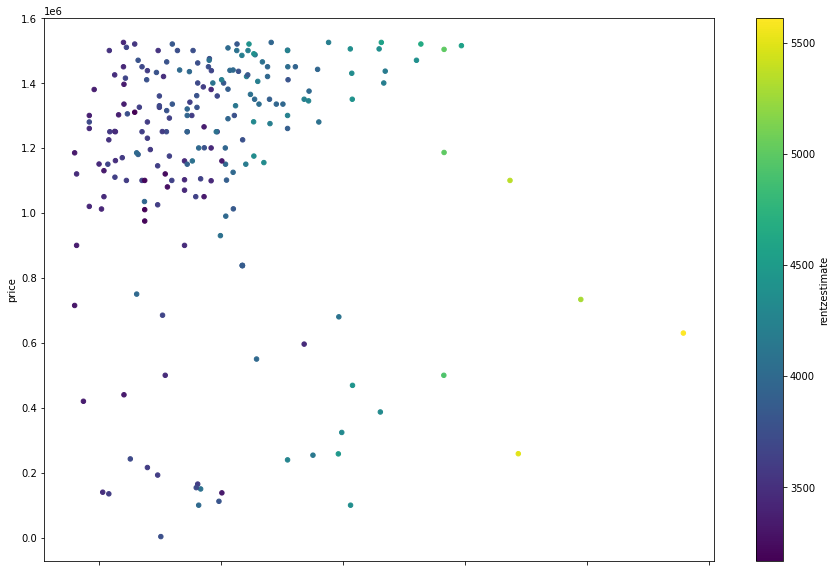

In [ ]:
#@title [SOLD] Scatter Plot for Price vs Living Space with Rentestimate Color { display-mode: "form" }

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

soldSingleFamilies.plot.scatter(
    x='livingArea',
    y='price',
    c='rentzestimate',
    colormap='viridis',
)

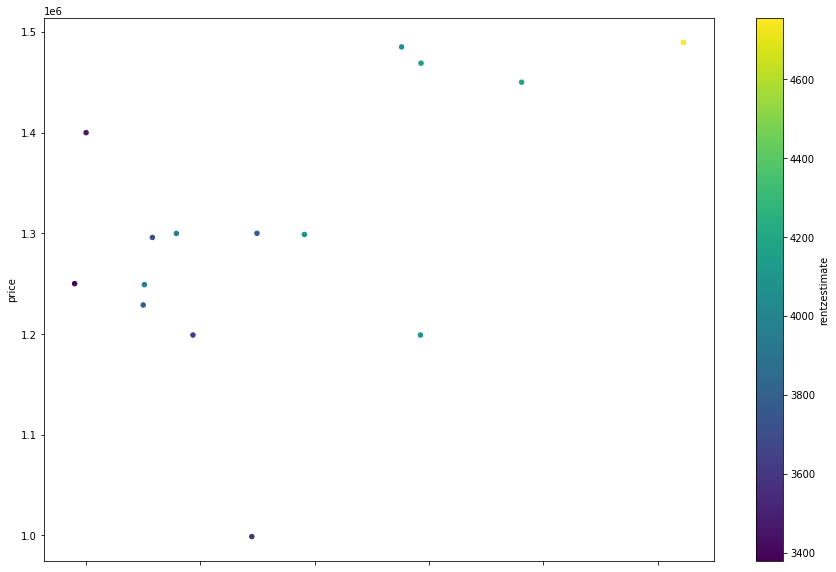

In [ ]:
#@title [FOR SALE] Scatter Plot for Price vs Living Space with Rentestimate Color { display-mode: "form" }
forSaleSingleFamilies.plot.scatter(
    x='livingArea',
    y='price',
    c='rentzestimate',
    colormap='viridis',
)

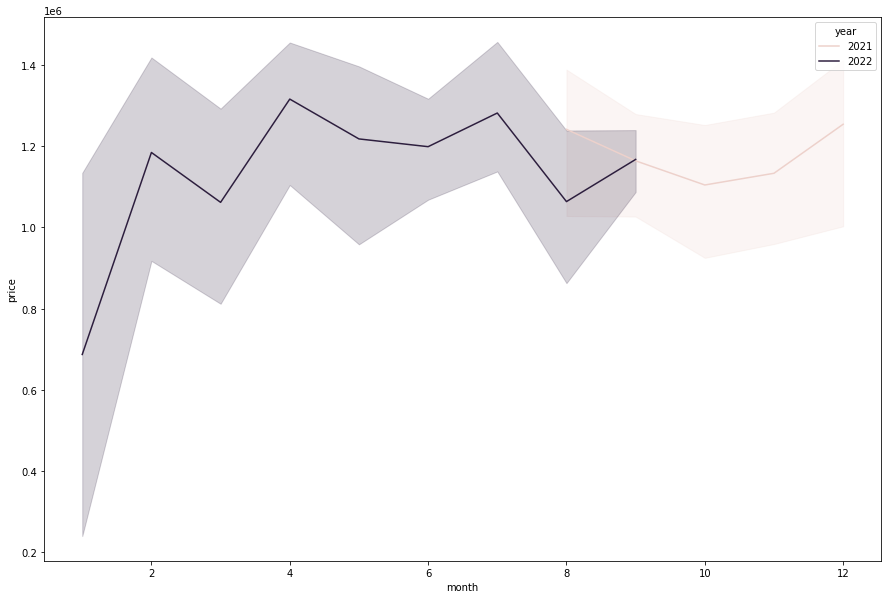

In [ ]:
#@title [SOLD] Plot historical price data { display-mode: "form" }
import seaborn as sns

tmp = soldSingleFamilies.copy()
tmp['dateSold'] = pd.to_datetime(soldSingleFamilies.lastSold.apply(lambda x: x.split(' ')[-1]), errors='coerce')
tmp = soldSingleFamilies[~soldSingleFamilies.dateSold.isnull()]
tmp2 = tmp.copy()
tmp2['month'] = tmp.dateSold.apply(lambda x: x.month)
tmp2['year'] = tmp.dateSold.apply(lambda x: x.year)
tmp2['day'] = tmp.dateSold.apply(lambda x: x.day)

sns.lineplot(x='month',y='price',hue='year',data=tmp2)
